In [2]:
import pandas as pd
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split


In [3]:
import pandas as pd

train = pd.read_csv("train.gz", compression='gzip', nrows=500000)  # load first 0.5M rows
test = pd.read_csv("test.gz", compression='gzip', nrows=100000)    # smaller sample

print(train.shape, test.shape)


(500000, 24) (100000, 23)


In [4]:
def extract_time_features(df):
    df['hour'] = df['hour'].astype(str)
    df['day'] = df['hour'].str[4:6].astype(int)
    df['hour_of_day'] = df['hour'].str[6:8].astype(int)
    df = df.drop(columns=['hour'])
    return df

train = extract_time_features(train)
test = extract_time_features(test)


In [5]:
# Separate target
y = train['click']
X = train.drop(['click', 'id'], axis=1)

# Drop 'id' from test too
test_ids = test['id']
test = test.drop(['id'], axis=1)


In [6]:
numeric_features = ['day', 'hour_of_day']
categorical_features = [col for col in X.columns if col not in numeric_features]


In [7]:
class MemoryReducer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        for col in X.select_dtypes(include=['int', 'float']).columns:
            X[col] = pd.to_numeric(X[col], downcast='integer')
        return X


In [8]:
class MultiColumnLabelEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, columns=None):
        self.columns = columns
        self.encoders = {}

    def fit(self, X, y=None):
        for col in self.columns:
            le = LabelEncoder()
            le.fit(X[col].astype(str))
            self.encoders[col] = le
        return self

    def transform(self, X):
        X_copy = X.copy()
        for col, le in self.encoders.items():
            X_copy[col] = le.transform(X_copy[col].astype(str))
        return X_copy


In [9]:
low_cardinality = ['banner_pos', 'device_type', 'device_conn_type']
high_cardinality = [c for c in categorical_features if c not in low_cardinality]


In [10]:
# Define sub-pipelines
numeric_pipeline = Pipeline([
    ('scaler', StandardScaler())
])

categorical_low_pipeline = Pipeline([
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

categorical_high_pipeline = Pipeline([
    ('label', MultiColumnLabelEncoder(columns=high_cardinality))
])

# Combine all with ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_pipeline, numeric_features),
        ('low_cat', categorical_low_pipeline, low_cardinality),
        # High cardinality handled outside (as it modifies original DataFrame)
    ],
    remainder='passthrough'
)


In [12]:
ctr_preprocessing_pipeline = Pipeline(steps=[
    ('reduce_mem', MemoryReducer()),
    ('label_high_card', MultiColumnLabelEncoder(columns=high_cardinality)),
    ('preprocessor', preprocessor)
])


In [14]:
!pip install lightgbm


ERROR: Could not install packages due to an OSError: [WinError 32] The process cannot access the file because it is being used by another process: 'C:\\Users\\mehta\\AppData\\Local\\Temp\\pip-unpack-pffc16ps\\lightgbm-4.6.0-py3-none-win_amd64.whl'
Consider using the `--user` option or check the permissions.


[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip



   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   ------------------------------

In [18]:
!pip install lightgbm


  Using cached lightgbm-4.6.0-py3-none-win_amd64.whl.metadata (17 kB)
   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   ---------------------------------------- 1.5/1.5 MB 15.1 MB/s eta 0:00:00



[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [20]:
!pip install shap

   ---------------------------------------- 0.0/548.0 kB ? eta -:--:--
   --------------------------------------- 548.0/548.0 kB 17.9 MB/s eta 0:00:00
   ---------------------------------------- 0.0/12.6 MB ? eta -:--:--
   ---------------- ----------------------- 5.2/12.6 MB 26.5 MB/s eta 0:00:01
   ---------------------------------- ----- 10.7/12.6 MB 26.8 MB/s eta 0:00:01
   ---------------------------------------- 12.6/12.6 MB 22.5 MB/s eta 0:00:00

   ---------------------------------------- 0/4 [slicer]
   ---------------------------------------- 0/4 [slicer]
  Attempting uninstall: numpy
   ---------------------------------------- 0/4 [slicer]
    Found existing installation: numpy 2.2.6
   ---------------------------------------- 0/4 [slicer]
   ---------- ----------------------------- 1/4 [numpy]
   ---------- ----------------------------- 1/4 [numpy]
   ---------- ----------------------------- 1/4 [numpy]
   ---------- ----------------------------- 1/4 [numpy]
   ---------- -

  You can safely remove it manually.
  You can safely remove it manually.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gensim 4.3.3 requires numpy<2.0,>=1.18.5, but you have numpy 2.1.3 which is incompatible.
tensorflow-intel 2.18.0 requires ml-dtypes<0.5.0,>=0.4.0, but you have ml-dtypes 0.5.1 which is incompatible.
tensorflow-intel 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 2.1.3 which is incompatible.
tensorflow-intel 2.18.0 requires tensorboard<2.19,>=2.18, but you have tensorboard 2.19.0 which is incompatible.
tf-keras 2.18.0 requires tensorflow<2.19,>=2.18, but you have tensorflow 2.19.0 which is incompatible.
thinc 8.3.2 requires numpy<2.1.0,>=2.0.0; python_version >= "3.9", but you have numpy 2.1.3 which is incompatible.

[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgr

In [22]:
!pip install numpy==2.1.0 --force-reinstall
!pip install numba==0.59.1 --force-reinstall
!pip install shap --upgrade --force-reinstall


   ---------------------------------------- 0.0/12.6 MB ? eta -:--:--
   --------- ------------------------------ 2.9/12.6 MB 15.2 MB/s eta 0:00:01
   ---------------------- ----------------- 7.1/12.6 MB 16.8 MB/s eta 0:00:01
   ----------------------------- ---------- 9.2/12.6 MB 14.6 MB/s eta 0:00:01
   ---------------------------------------  12.3/12.6 MB 14.6 MB/s eta 0:00:01
   ---------------------------------------- 12.6/12.6 MB 13.6 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.1.3
    Uninstalling numpy-2.1.3:
      Successfully uninstalled numpy-2.1.3


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gensim 4.3.3 requires numpy<2.0,>=1.18.5, but you have numpy 2.1.0 which is incompatible.
tensorflow-intel 2.18.0 requires ml-dtypes<0.5.0,>=0.4.0, but you have ml-dtypes 0.5.1 which is incompatible.
tensorflow-intel 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 2.1.0 which is incompatible.
tensorflow-intel 2.18.0 requires tensorboard<2.19,>=2.18, but you have tensorboard 2.19.0 which is incompatible.
tf-keras 2.18.0 requires tensorflow<2.19,>=2.18, but you have tensorflow 2.19.0 which is incompatible.
thinc 8.3.2 requires numpy<2.1.0,>=2.0.0; python_version >= "3.9", but you have numpy 2.1.0 which is incompatible.

[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.


  Using cached numpy-1.26.4-cp312-cp312-win_amd64.whl.metadata (61 kB)
   ---------------------------------------- 0.0/2.7 MB ? eta -:--:--
   ---------------------------------------- 2.7/2.7 MB 14.0 MB/s eta 0:00:00
   ---------------------------------------- 0.0/28.1 MB ? eta -:--:--
   --- ------------------------------------ 2.6/28.1 MB 10.1 MB/s eta 0:00:03
   ---- ----------------------------------- 3.4/28.1 MB 7.2 MB/s eta 0:00:04
   ----- ---------------------------------- 4.2/28.1 MB 5.9 MB/s eta 0:00:05
   ------ --------------------------------- 4.5/28.1 MB 5.5 MB/s eta 0:00:05
   ------- -------------------------------- 5.2/28.1 MB 4.8 MB/s eta 0:00:05
   --------- ------------------------------ 6.6/28.1 MB 4.8 MB/s eta 0:00:05
   ---------- ----------------------------- 7.3/28.1 MB 4.6 MB/s eta 0:00:05
   ----------- ---------------------------- 8.1/28.1 MB 4.5 MB/s eta 0:00:05
   ------------ --------------------------- 8.9/28.1 MB 4.4 MB/s eta 0:00:05
   ------------- -


blis 1.0.1 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.
inference-sdk 0.52.1 requires numpy<2.3.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.
tensorflow-intel 2.18.0 requires ml-dtypes<0.5.0,>=0.4.0, but you have ml-dtypes 0.5.1 which is incompatible.
tensorflow-intel 2.18.0 requires tensorboard<2.19,>=2.18, but you have tensorboard 2.19.0 which is incompatible.
tf-keras 2.18.0 requires tensorflow<2.19,>=2.18, but you have tensorflow 2.19.0 which is incompatible.
thinc 8.3.2 requires numpy<2.1.0,>=2.0.0; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.

[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


  You can safely remove it manually.
  You can safely remove it manually.
  You can safely remove it manually.
  You can safely remove it manually.
  You can safely remove it manually.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gensim 4.3.3 requires numpy<2.0,>=1.18.5, but you have numpy 2.3.4 which is incompatible.
gensim 4.3.3 requires scipy<1.14.0,>=1.7.0, but you have scipy 1.16.3 which is incompatible.
inference-sdk 0.52.1 requires numpy<2.3.0,>=2.0.0, but you have numpy 2.3.4 which is incompatible.
langchain-core 0.3.45 requires packaging<25,>=23.2, but you have packaging 25.0 which is incompatible.
langsmith 0.3.17 requires requests-toolbelt<2.0.0,>=1.0.0, but you have requests-toolbelt 0.10.1 which is incompatible.
streamlit 1.43.2 requires packaging<25,>=20, but you have packaging 25.0 which is incompatible.
tensorflow 2.19.0 requires numpy<2.2.0,


  Using cached shap-0.49.1-cp312-cp312-win_amd64.whl.metadata (25 kB)
  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
  Using cached packaging-25.0-py3-none-any.whl.metadata (3.3 kB)
  Using cached slicer-0.0.8-py3-none-any.whl.metadata (4.0 kB)
  Using cached cloudpickle-3.1.1-py3-none-any.whl.metadata (7.1 kB)
  Using cached colorama-0.4.6-py2.py3-none-any.whl.metadata (17 kB)
  Using cached python_dateutil-2.9.0.post0-py2.py3-none-any.whl.metadata (8.4 kB)
  Using cached pytz-2025.2-py2.py3-none-any.whl.metadata (22 kB)
  Using cached tzdata-2025.2-py2.py3-none-any.whl.metadata (1.4 kB)
  Using cached six-1.17.0-py2.py3-none-any.whl.metadata (1.7 kB)
Using cached shap-0.49.1-cp312-cp312-win_amd64.whl (548 kB)
Using cached slicer-0.0.8-py3-none-any.whl (15 kB)
   ---------------------------------------- 0.0/2.7 MB ? eta -:--:--
   ---------------------------------------- 2.7/2.7 MB 14.4 MB/s eta 0:00:00
   ---------------------------------------- 0.0/38.1 MB ? eta -:--:

In [28]:
# Install dependencies
!pip install -q numpy==1.26.4 pandas scikit-learn==1.4.2 lightgbm==4.3.0 shap==0.44.1 joblib matplotlib

print("✅ All dependencies installed successfully!")


✅ All dependencies installed successfully!


  error: subprocess-exited-with-error
  
  exit code: 1
  
  [215 lines of output]
  C:\Users\mehta\AppData\Local\Temp\pip-build-env-a_l5aqaa\overlay\Lib\site-packages\setuptools\config\_apply_pyprojecttoml.py:82: SetuptoolsDeprecationWarning: `project.license` as a TOML table is deprecated
  !!
  
          ********************************************************************************
          Please use a simple string containing a SPDX expression for `project.license`. You can also use `project.license-files`. (Both options available on setuptools>=77.0.0).
  
          By 2026-Feb-18, you need to update your project and remove deprecated calls
          or your builds will no longer be supported.
  
          See https://packaging.python.org/en/latest/guides/writing-pyproject-toml/#license for details.
          ********************************************************************************
  
  !!
    corresp(dist, value, root_dir)
  C:\Users\mehta\AppData\Local\Temp\pip-build

In [11]:
from sklearn.preprocessing import LabelEncoder

# Target variable
y = train['click']
X = train.drop(['click', 'id'], axis=1)

# Encode categorical columns
for col in X.columns:
    if X[col].dtype == 'object':
        X[col] = LabelEncoder().fit_transform(X[col].astype(str))

print("✅ Categorical encoding done!")


✅ Categorical encoding done!


In [12]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)


Train shape: (400000, 23)
Test shape: (100000, 23)


In [13]:
import lightgbm as lgb

# Prepare data
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)

# Model parameters
params = {
    'objective': 'binary',
    'metric': 'auc',
    'boosting_type': 'gbdt',
    'learning_rate': 0.05,
    'num_leaves': 64,
    'max_depth': -1,
    'verbose': -1
}

# ✅ Use callbacks for early stopping and logging
callbacks = [
    lgb.early_stopping(stopping_rounds=20),
    lgb.log_evaluation(period=50)
]

# Train model
model = lgb.train(
    params,
    lgb_train,
    valid_sets=[lgb_eval],
    num_boost_round=200,
    callbacks=callbacks
)

print("✅ Model trained successfully!")


Training until validation scores don't improve for 20 rounds
[50]	valid_0's auc: 0.749793
[100]	valid_0's auc: 0.755608
[150]	valid_0's auc: 0.757898
[200]	valid_0's auc: 0.75939
Did not meet early stopping. Best iteration is:
[200]	valid_0's auc: 0.75939
✅ Model trained successfully!


In [14]:
from sklearn.metrics import roc_auc_score

y_pred = model.predict(X_test)
auc = roc_auc_score(y_test, y_pred)
print(f"✅ Model AUC: {auc:.4f}")


✅ Model AUC: 0.7594


In [15]:
# Add predictions for ranking demo
rank_df = X_test.copy()
rank_df['predicted_ctr'] = y_pred

# Sort ads by predicted CTR (descending)
rank_df = rank_df.sort_values(by='predicted_ctr', ascending=False)

print("Top 5 recommended ads based on predicted CTR:")
rank_df.head(5)


Top 5 recommended ads based on predicted CTR:


,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,device_id,device_ip,...,C15,C16,C17,C18,C19,C20,C21,day,hour_of_day,predicted_ctr
247659,1005,0,920,1217,6,967,25,18,23688,51610,...,320,50,122,3,1319,-1,15,21,1,0.877775
196869,1005,0,920,1217,6,961,17,2,27538,56846,...,320,50,112,3,1319,-1,15,21,1,0.854247
220914,1005,0,920,1217,6,961,17,2,27538,58739,...,320,50,112,3,1319,-1,15,21,1,0.854247
90282,1005,0,920,1217,6,961,17,2,27538,116061,...,320,50,112,3,1319,-1,15,21,0,0.852852
38130,1005,0,920,1217,6,961,17,2,27538,56846,...,320,50,112,3,1319,-1,15,21,0,0.851631


In [ ]:
!pip install -q --force-reinstall scikit-learn==1.4.2 shap==0.44.1 lightgbm==4.3.0 numpy==1.26.4 pandas==2.2.2 matplotlib==3.8.4 joblib==1.4.2

import os
os._exit(0)  # 🔄 Restart kernel automatically (important)


✅ All libraries imported successfully!
SHAP: 0.49.1
LightGBM: 4.6.0


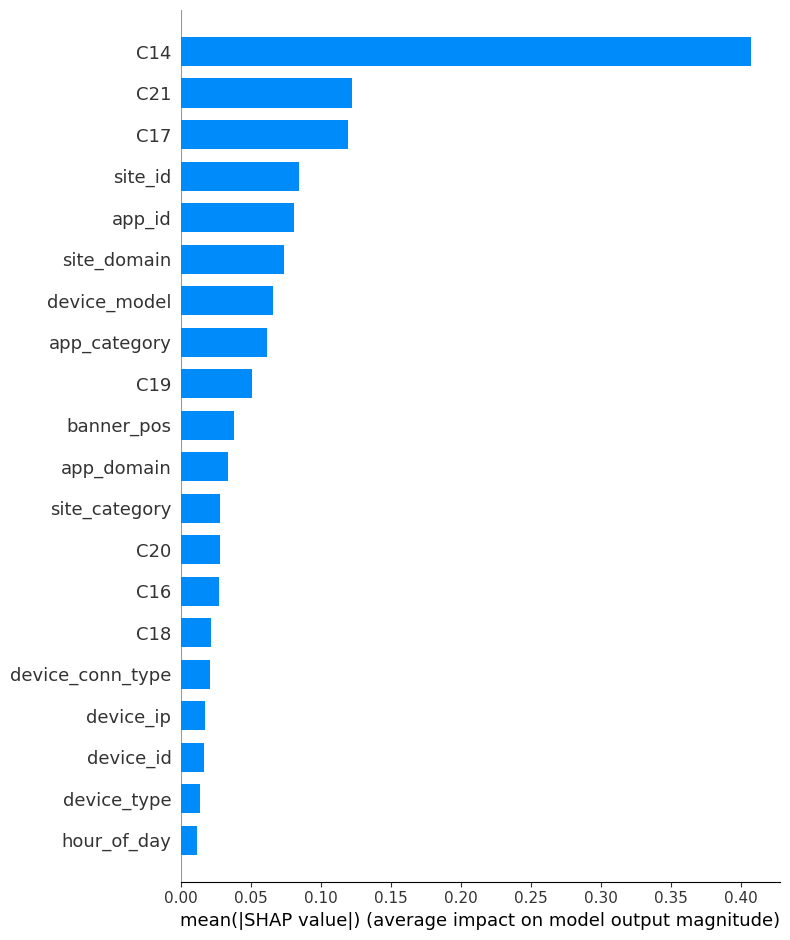

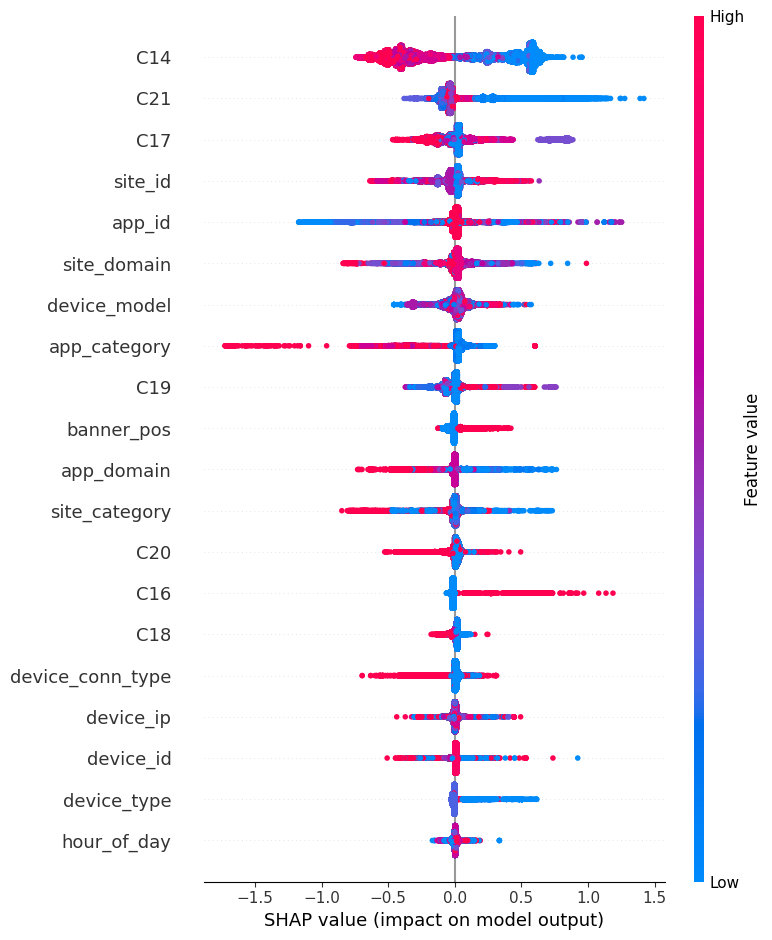

In [16]:
import shap
import lightgbm as lgb
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score

print("✅ All libraries imported successfully!")
print("SHAP:", shap.__version__)
print("LightGBM:", lgb.__version__)

# --- SHAP Visualization Example ---
# Assuming you already have `model`, `X_test`, `y_test` defined

# Create SHAP explainer
explainer = shap.Explainer(model)
shap_values = explainer(X_test)

# Summary bar plot
shap.summary_plot(shap_values.values, X_test, plot_type="bar", show=True)

# Optional detailed summary
shap.summary_plot(shap_values.values, X_test, show=True)


In [18]:
import joblib

joblib.dump(model, "ctr_model_lgb.pkl")
print("✅ Model saved as ctr_model_lgb.pkl")


✅ Model saved as ctr_model_lgb.pkl


C:\Users\mehta\AppData\Local\Programs\Python\Python312\Lib\site-packages\shap\explainers\_tree.py:586: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


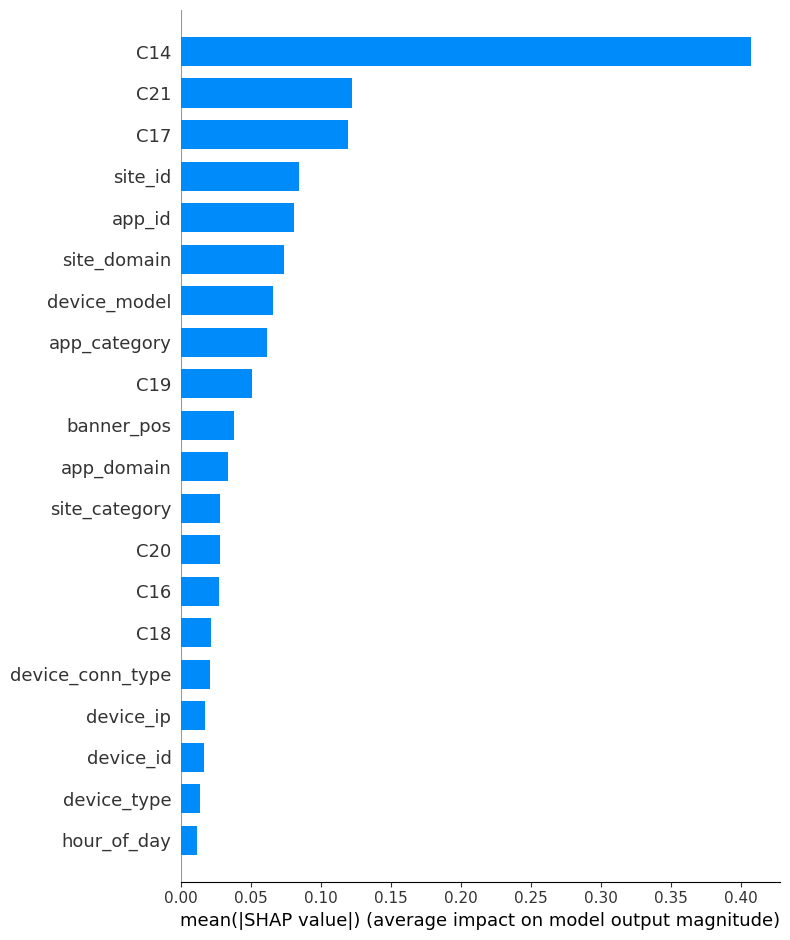

In [17]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

# Summary bar plot
shap.summary_plot(shap_values, X_test, plot_type="bar", show=True)


In [19]:
import joblib
import pandas as pd

# Load the saved model
model = joblib.load("ctr_model_lgb.pkl")

# Example: Predict on test data
y_pred_proba = model.predict(X_test)
y_pred = (y_pred_proba > 0.5).astype(int)

print("✅ Predictions generated successfully!")


✅ Predictions generated successfully!


In [20]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score

# Evaluate model performance
print("🔹 ROC AUC Score:", roc_auc_score(y_test, y_pred_proba))
print("🔹 Accuracy:", accuracy_score(y_test, y_pred))
print("\n✅ Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\n✅ Classification Report:\n", classification_report(y_test, y_pred))


🔹 ROC AUC Score: 0.7593901323753115
🔹 Accuracy: 0.84048

✅ Confusion Matrix:
 [[82181  1412]
 [14540  1867]]

✅ Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.98      0.91     83593
           1       0.57      0.11      0.19     16407

    accuracy                           0.84    100000
   macro avg       0.71      0.55      0.55    100000
weighted avg       0.80      0.84      0.79    100000



In [21]:
# Save both model and feature names
joblib.dump((model, list(X_train.columns)), "ctr_model_lgb.pkl")
print("✅ Model and feature names saved successfully!")


✅ Model and feature names saved successfully!
